In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.nn import Sequential
from PIL import Image
import torch.nn.functional as F

In [2]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [7]:
# Definir un dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {}
        
        # Recorrer los directorios e imágenes para almacenar las rutas y etiquetas
        for label_idx, label_name in enumerate(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label_name)
            if os.path.isdir(label_dir):
                self.label_map[label_idx] = label_name
                for image_name in os.listdir(label_dir):
                    if image_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(label_dir, image_name))
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
transform_data = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
    # transforms.Resize(()),
)

In [10]:
train_data = CustomImageDataset("./data/train/", transform_data)
test_data = CustomImageDataset("./data/test/", transform_data)

In [ ]:
len(train_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


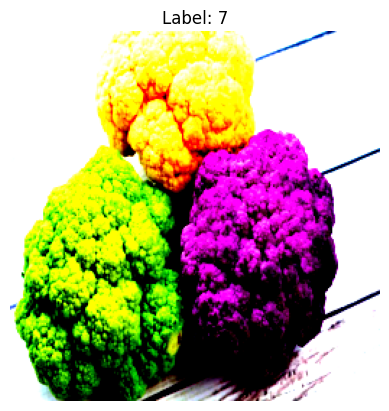

In [12]:
import random
import matplotlib.pyplot as plt

# Seleccionar un índice aleatorio
random_idx = random.randint(0, len(train_data) - 1)

# Obtener la imagen y la etiqueta correspondiente
image, label = train_data[random_idx]

# Convertir la imagen de tensor a numpy array para poder visualizarla con matplotlib
image = image.permute(1, 2, 0).numpy()

# Mostrar la imagen
plt.imshow(image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # self.dropxd = nn.Dropout(0.4)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Después de las convoluciones y max pooling, las imágenes de entrada de tamaño 128x128 se reducirán a 16x16
        # self.fc1 = nn.Linear(64 * 16 * 16, 128)
        # self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        print(x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        # x = x.view(-1, 64 * 16 * 16)  # Aplanar el tensor
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        return x

# Crear una instancia del modelo y moverlo a la GPU si está disponible
num_classes = 4  # Ajusta esto según el número de categorías que tengas (banana, manzana, toronja, piña)
model = SimpleCNN(num_classes=num_classes).to(device)

In [13]:
# Cargar el modelo preentrenado ResNet
model = models.resnet18(pretrained=True)

# Ajustar las capas finales del modelo
num_ftrs = model.fc.in_features
num_classes = 36  # Ajusta esto según el número de categorías que tengas
model.fc = nn.Linear(num_ftrs, num_classes)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
dataset_train = DataLoader(train_data, batch_size=128, shuffle=True)
dataset_test = DataLoader(test_data, batch_size=128, shuffle=True)

In [3]:
import torch.optim as optim

In [4]:
from tqdm import tqdm

In [15]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
train_accuracies = []
# running_lossa = []
# Entrenar el modelo

num_epochs = 10  # Ajusta el número de épocas según sea necesario

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in tqdm(dataset_train):
        images = images.to(device)
        labels = labels.to(device)

        # Limpiar los gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calcular la pérdida
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        # Acumular la pérdida de esta iteración
        running_loss += loss.item()

        # Calcular el número de predicciones correctas
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calcular y guardar la pérdida media de la época
    epoch_loss = running_loss / len(dataset_train)
    train_losses.append(epoch_loss)

    # Calcular y guardar el accuracy de la época
    epoch_accuracy = correct_predictions / total_predictions
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy * 100:.2f}%')

print('Finished Training')


  0%|          | 0/24 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 24/24 [02:36<00:00,  6.50s/it]


Epoch [1/10], Loss: 2.2875209947427115, Accuracy: 48.29%


100%|██████████| 24/24 [03:11<00:00,  7.99s/it]


Epoch [2/10], Loss: 0.8695590570569038, Accuracy: 82.76%


100%|██████████| 24/24 [03:50<00:00,  9.61s/it]


Epoch [3/10], Loss: 0.481850553303957, Accuracy: 90.79%


100%|██████████| 24/24 [03:44<00:00,  9.36s/it]


Epoch [4/10], Loss: 0.2833674432088931, Accuracy: 95.56%


100%|██████████| 24/24 [02:21<00:00,  5.88s/it]


Epoch [5/10], Loss: 0.17574214873214564, Accuracy: 97.63%


100%|██████████| 24/24 [02:24<00:00,  6.03s/it]


Epoch [6/10], Loss: 0.1088370510066549, Accuracy: 98.82%


100%|██████████| 24/24 [02:07<00:00,  5.32s/it]


Epoch [7/10], Loss: 0.07732511078938842, Accuracy: 99.01%


100%|██████████| 24/24 [02:06<00:00,  5.27s/it]


Epoch [8/10], Loss: 0.054384799053271614, Accuracy: 99.14%


100%|██████████| 24/24 [02:06<00:00,  5.25s/it]


Epoch [9/10], Loss: 0.04665407453042766, Accuracy: 99.21%


100%|██████████| 24/24 [02:06<00:00,  5.28s/it]

Epoch [10/10], Loss: 0.04132515207553903, Accuracy: 99.11%
Finished Training


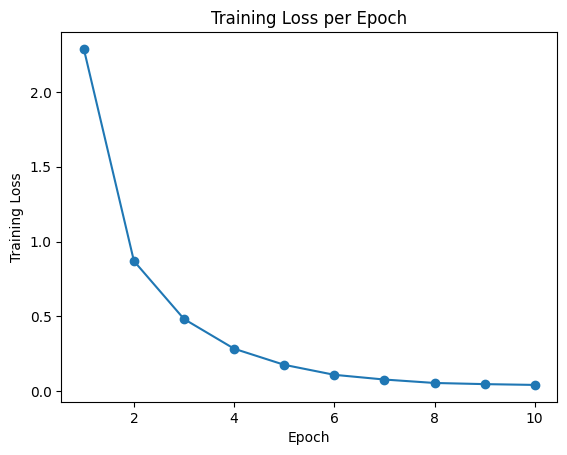

In [16]:
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')
plt.show()

Text(0.5, 1.0, 'Training Accuracy per Epoch')

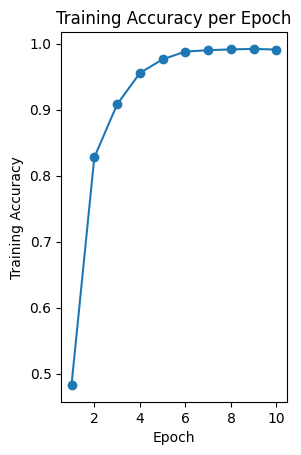

In [17]:
# Graficar el accuracy de entrenamiento
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch')

In [18]:
# Suponiendo que tienes un conjunto de datos de prueba
# test_dataset = CustomImageDataset(root_dir='/path/to/test', transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

validation_dataset = CustomImageDataset("./data/validation/", transform_data)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
# # Evaluar el modelo
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in dataset_test:
#         labels = torch.tensor([test_data.labels.index(label) for label in labels])
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the model on the test images: {100 * correct / total}%')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(dataset_test):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')



100%|██████████| 3/3 [00:21<00:00,  7.23s/it]

Accuracy of the model on the test images: 97.45042492917847%


In [ ]:
torch.save(model.state_dict(), "RESNET_MODELO.pt")

In [ ]:
torch.save(model.state_dict(), "BEST_MODEL.pt")

In [19]:
torch.save(model, "modeloFinal.pt")

In [20]:
mymodel = torch.load("modeloFinal.pt")
# model.load_state_dict(mymodel)

C:\Users\user\AppData\Local\Temp\ipykernel_6592\3594299868.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mymodel = torch.load("modeloFinal.pt")


In [21]:
validation_dataset = CustomImageDataset("./data/validation/", transform_data)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
# # Evaluar el modelo
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in dataset_test:
#         labels = torch.tensor([test_data.labels.index(label) for label in labels])
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the model on the test images: {100 * correct / total}%')

mymodel.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(dataset_test):
        images = images.to(device)
        labels = labels.to(device)
        outputs = mymodel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:19<00:00,  6.62s/it]

Accuracy of the model on the test images: 97.45042492917847%


In [24]:
for label in os.listdir(os.path.join("./data/train/")):
    print(label)
    with open("labels_frutas_verduras.txt", mode="a") as file:
        file.write(f"{label}\n")

apple
banana
beetroot
bell pepper
cabbage
capsicum
carrot
cauliflower
chilli pepper
corn
cucumber
eggplant
garlic
ginger
grapes
jalepeno
kiwi
lemon
lettuce
mango
onion
orange
paprika
pear
peas
pineapple
pomegranate
potato
raddish
soy beans
spinach
sweetcorn
sweetpotato
tomato
turnip
watermelon


In [27]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import torch
import torchvision.transforms as transforms
# from torchvision.models import resnet18
import os


def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load("./modeloFinal.pt", map_location=device)
    model.eval()
    return model, device

def predict_image(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

def load_labels(path_labels):
    labels = []
    with open(str(path_labels)) as file:
        labels.extend(file.readlines())
    return labels 
los_nombres = load_labels("./labels_frutas_verduras.txt")
# Cargar el modelo
model, device = load_model()


def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = Image.open(file_path)
        image = image.resize((250, 250))
        photo = ImageTk.PhotoImage(image)
        image_label.config(image=photo)
        image_label.image = photo
        
        prediction = predict_image(file_path, model, device)
        result_label.config(text=f"Predicción:{los_nombres[prediction]}")

# Configuración de la ventana principal
root = tk.Tk()
root.title("Predicción de Imagen con ResNet18")



# Crear widgets
open_button = tk.Button(root, text="Abrir Imagen", command=open_image)
image_label = tk.Label(root)
result_label = tk.Label(root, text="Predicción: ")

# Colocar widgets en la ventana
open_button.pack(pady=10)
image_label.pack()
result_label.pack(pady=10)

# Iniciar el bucle principal
root.mainloop()

C:\Users\user\AppData\Local\Temp\ipykernel_6592\1689175320.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./modeloFinal.pt", map_location=device)


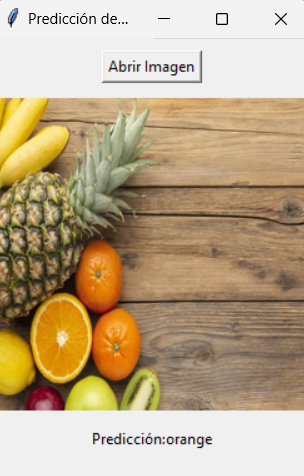 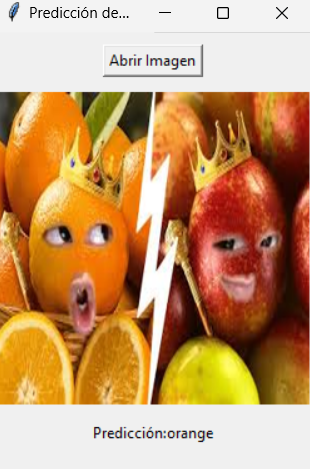